In [5]:
%load_ext zipline
# Necessary imports
import os
import zipline
from zipline.api import (order_target_percent, symbol, set_commission, set_slippage,
 schedule_function, date_rules, time_rules)
from pandas import Timestamp
from zipline.data.bundles import load
from zipline.api import order, record, symbol, get_open_orders
import pandas as pd
import zipline
import os
from pandas import Timestamp
from trading_calendars import get_calendar
from zipline.data.bundles import load
from zipline.api import order, record, symbol, set_benchmark
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
from trading_calendars import get_calendar
#trading_calendar=get_calendar('24/7')
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
import talib as ta
import pytz
import pandas_datareader.data as web
from os import listdir
import numpy as np
from matplotlib import style

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [12]:
#!zipline ingest --bundle universe

In [14]:
now = Timestamp.utcnow()
bundle = load('universe', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))
symbols = list(symbols)
print('This is our universe. We trade among these ' + str(len(symbols)) + ' instruments.')
print(list(symbols))

This is our universe. We trade among these 7 instruments.
['AVAX', 'FLOW', 'ADA', 'MANA', 'SOL', 'MATIC', 'TFUEL']


In [9]:
def initialize(context):
    pass
def handle_data(context, data):
    slowma = data.history(symbol("SOL"), fields='price', bar_count=50, frequency='1d').mean()
    fastma = data.history(symbol("SOL"), fields='price', bar_count=10, frequency='1d').mean()
    if fastma < slowma:
        if symbol("SOL") not in get_open_orders():
            order_target_percent(symbol("SOL"), 0.04)

    if fastma > slowma:
        if symbol("SOL") not in get_open_orders():
            order_target_percent(symbol("SOL"), 0.96)

    record(SOL=data.current(symbol('SOL'), fields='price'))

In [10]:
start_date = pd.Timestamp('2020-01-05', tz='utc')
end_date = pd.Timestamp('2021-03-01', tz='utc')
# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('24/7'),
                            initialize=initialize,
                            capital_base=100000,
                            handle_data=handle_data,
                            bundle='universe',
                            data_frequency='daily')

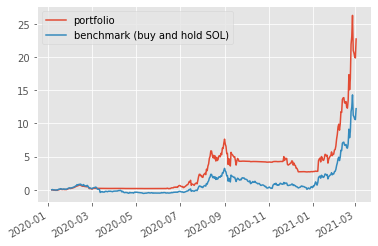

In [11]:
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SOL.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark (buy and hold SOL)')
plt.legend(loc=2)

plt.show()

### Description of strategy
Let’s define our trading strategy:
- Our stock universe consists of 7 stocks.
- The maximum portfolio size is kept at 30 so we have zero to thirty stocks in our portfolio at any given time.
- We are going to rebalance only on a monthly basis to avoid excessive trading and associated cost.
- There is a trading fee of 0.4%.
- We will use 14 periods of RSI to define our buy and sell logic. We will calculate the RSI of these 7 stocks every month and create a ranking table. If the RSI is less than 30 for a stock and we are not already holding it then it is in our buy list. If the stock has an RSI of more than 70 and we are holding it, we exit the position. We keep the maximum portfolio size at not more than 30 stocks.
- We do the position allocation based on the mean of 20 days rolling standard deviation for 126 days time period. This ensures the position allocation is based on risk parity, meaning the stock will have weights based on equal risk, less the volatility of stock more the weightage.
### Description of python code
- We do the necessary imports of python libraries. 
- Define the testing date ranges and convert the time zone to UTC.
- Read all csv files in the data/data folder and create a list of 7 tickers.
- Define model parameters including initial portfolio size, the upper and lower limit of RSI, RSI period, a rolling window for standard deviation, maximum portfolio size, commission, and slippage parameters.
- The function compute_rsi calculates the 14 days RSI and returns the last element of the time series. I have used python library ta-lib for this however you can choose any suitable library for this job. Few other options include ta or finta.
- In the volatility function, we take a 126-day time series of closing prices, calculate the daily returns, and take a mean of 20 days rolling window of standards deviation.
- The function output_progress is just to track the progress output and display monthly returns during backtest execution.
- We initialize the commission, slippage, and tickers in the function initialize and schedule the rebalancing on a monthly basis.
- The function rebalance is the core of our strategy and I will describe it in detail in the next couple of points. First, we call output_progress to display monthly progress during backtesting. Then we get zipline symbol for each ticker. Next, we fetch historical daily closing pricing for 126 time periods.
- Next, we invoke compute_rsi function by passing historically closing pricing time series for each ticker and create a ranking table of ticker and corresponding RSI value in ascending order.
- Now, let’s work on the selling logic first. We get the existing portfolio ticker list using the variable kept_positions. Then, for each existing security in the portfolio, we check if it is part of our universe, if not we order the target percentage to zero and remove the security from the variable kept_positions. Then, in elif we check if the RSI value of the security is more than the upper bound if so we exit the position and set the target percentage to zero.
- We will move to our ticker selection logic. We identify the number of stocks to replace by the difference between maximum portfolio size and the length of the variable kept_positions. Now, we create a buy list without including stocks in the variable kept_positions. Then, from this buy list, we take a number of securities equal to replacement length where the RSI is less than the lower threshold.
- Finally, we make a new portfolio by joining the buy list with securities in the variable kept_positions.
- Let’s discuss the position allocation now. We can have multiple options to use such as 1/n (equal weights), efficient frontier optimization, or equal risk parity. I have used 1/n option in my previous post — Momentum Strategy using Backtrader with BSE 500 as Stocks Universe and got very good results. We will keep the efficient frontier optimization for some other day and for now go with equal risk parity. That means the weight of each security will be in accordance with its risk which is measured using standard deviation. Higher the risk lower the weight. We calculate the volatility table by taking a mean of 20 days rolling standard deviation for 126 days time period for each security in the new portfolio table. To get the individual security weight, we take the inverse of the volatility table and divide it by the sum of the inverse table.
- Almost done with rebalancing logic, we have the new portfolio of securities and corresponding weights. We iterate all the items in the new portfolio and if the security is in the kept position list or if the RSI is lower than the threshold, we order the target percentage.
- In the function analyze we just calculate the annualized returns and print it along with maximum drawdown.
- Finally, its time to run the algorithm with our earlier defined date range, initial capital, and bundle as your custom bundle.

In [15]:
# for dataframe slicing operations
idx = pd.IndexSlice
# Testing date range
start = pd.Timestamp('2021-01-05', tz='utc')
end = pd.Timestamp('2022-01-05', tz='utc')
# Commission and Slippage Parameters
enable_commission = True
commission_pct = 0.004
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05
TICKERS = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']
intial_portfolio = 500000
rsi_period = 14
vola_window = 20
mportfolio_size = 4
upper = 70
lower = 30

In [16]:
# function to calculate RSI
def compute_rsi(close):
    rsi = ta.RSI(close.values, timeperiod=rsi_period)
    return rsi[-1]
# function to calculate volatility
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean()
    return std
# output performance
def output_progress(context):
    # Output performance numbers during backtest run on monthly basis
    # Get today's date
    today = zipline.api.get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

def initialize(context):
    context.universe  = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']
    context.vola_window = 20
     # Used only for progress output.
    context.last_month = intial_portfolio   
    # Fetch and store index tickers
    context.index_members = TICKERS
def handle_data(context, data):
    # Write progress output during the backtest
    output_progress(context)
    
     # Finally, get the Zipline symbols for the tickers
    coins =   [symbol(ticker) for ticker in context.universe]
    
    # Get historical data for volatility calculation
    hist = data.history(coins, "close", 20, "1d")
    hist = hist.dropna()
    
     # Make momentum ranking table based on RSI
    ranking_table = hist.apply(compute_rsi)
    ranking_table = ranking_table.sort_values(ascending=True)
    ranking_table.to_csv('ranking/ranking_table.csv')
    
    # Sell Logic
    # First we check if any existing position should be sold.
    # Sell if stock has RSI greater than upper value.
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] > upper:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)

        
        
     # Stock Selection Logic
    # Check how many stocks we are keeping from last month.
    # Take the desired number of stock from the ranking table where RSI is less than lower.
    replacement_stocks = mportfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions)]
    buy_list = buy_list[buy_list.loc[buy_list.index] < lower].dropna()[:replacement_stocks]    
    new_portfolio = pd.concat((buy_list,ranking_table.loc[ranking_table.index.isin(kept_positions)]))
    
     # Calculate inverse volatility for stocks,and make target position weights.
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    print(vola_target_weights)
    
     
    # Rebalance the tickers based on new weights
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] < lower:
                order_target_percent(security, weight)
    #tracking the prices of all coins
    record(SOL=data.current(symbol('SOL'), 'price'),
           TFUEL=data.current(symbol('TFUEL'), 'price'),
           MATIC=data.current(symbol('MATIC'), 'price'),
           FLOW=data.current(symbol('FLOW'), 'price'),
           MANA=data.current(symbol('MANA'), 'price'),
            ADA=data.current(symbol('ADA'), 'price'),
            AVAX=data.current(symbol('AVAX'), 'price'),
          )

In [17]:
start = pd.Timestamp('2021-05-05', tz='utc')
end = pd.Timestamp('2022-01-05', tz='utc')
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
   # analyze=analyze, 
    capital_base=intial_portfolio, 
    handle_data = handle_data,
    data_frequency = 'daily', 
    bundle= 'universe')

2021-05-05 - Last Month Result: 0.00%
Series([], dtype: float64)
2021-05-06 - Last Month Result: 0.00%
Series([], dtype: float64)
2021-05-07 - Last Month Result: 0.00%
Series([], dtype: float64)
2021-05-10 - Last Month Result: 0.00%
Equity(2 [FLOW])   NaN
dtype: float64


/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


ValueError: cannot convert float NaN to integer

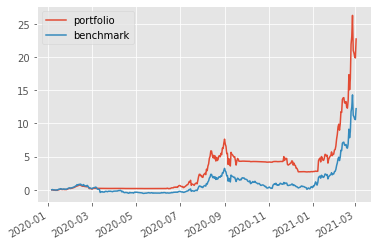

In [18]:
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SOL.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)
plt.show()

# Second model

In [22]:
import numpy as np

from zipline.finance import commission, slippage

STOCKS = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=4):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.window_length = window_length
    algo.set_commission(commission.PerShare(cost=0))
    algo.set_slippage(slippage.FixedSlippage(spread=0))


def handle_data(algo, data):
    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price
        
   #print(x_tilde)
    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)
    
    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm
    
    record(SOL=data.current(symbol('SOL'), 'price'),
           TFUEL=data.current(symbol('TFUEL'), 'price'),
           MATIC=data.current(symbol('MATIC'), 'price'),
           FLOW=data.current(symbol('FLOW'), 'price'),
           MANA=data.current(symbol('MANA'), 'price'),
            ADA=data.current(symbol('ADA'), 'price'),
            AVAX=data.current(symbol('AVAX'), 'price'),
          )


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    for i, sid in enumerate(algo.sids):
        algo.order_target_percent(sid, desired_port[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

In [23]:
start = pd.Timestamp('2021-08-05', tz='utc')
end = pd.Timestamp('2022-01-05', tz='utc')
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
   # analyze=analyze, 
    capital_base=intial_portfolio, 
    handle_data = handle_data,
    data_frequency = 'daily', 
    bundle= 'universe')

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


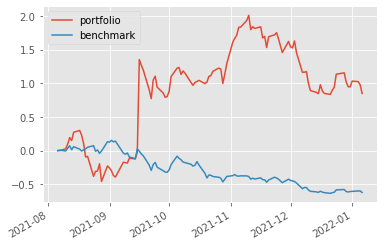

In [24]:
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.FLOW.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)
plt.show()

In [18]:
market_caps = []
latest_prices = []
tickers = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']
for ticker in tickers:
    df = pd.read_csv("../data/instruments/" + ticker + ".csv")
    latest_price = df.Close.tail(1).values[0]
    latest_volume = df.Volume.tail(1).values[0]
    market_caps.append(latest_price*latest_volume)
    latest_prices.append(latest_price)
data = {'coin': ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX'], 'last_prices': latest_prices, 'market_caps': market_caps} 
table = pd.DataFrame(data)
table

,coin,last_prices,market_caps
0,SOL,99.968445,2.285474e+11
1,TFUEL,0.158230,7.020063e+06
2,MATIC,1.332221,8.888690e+08
3,FLOW,5.414602,5.462162e+08
4,MANA,2.069002,6.689162e+08
5,ADA,0.933872,1.307575e+09
6,AVAX,73.856758,8.716657e+10


# Benchmark
## Calculating portfolio returns with an equal weighted index
- Finish defining the numpy array of model portfolio_weights with the values.
- Use the .mul() method to multiply the portfolio_weights across the rows of CoinReturns to get weighted stock returns.
- Then use the .sum() method across the rows on the WeightedReturns object to calculate the portfolio returns.
- Finally, review the plot of cumulative returns over time.

In [19]:
coins = perf[TICKERS]
coins.head(2)

,SOL,TFUEL,MATIC,FLOW,MANA,ADA,AVAX
2021-08-05 20:00:00+00:00,37.355,0.326,1.065,22.320,0.736,1.386,13.834
2021-08-06 20:00:00+00:00,39.446,0.316,1.081,22.469,0.750,1.402,14.725


Now we will calculate the asset returns in our portfolio.

In [20]:
CoinReturns = coins.pct_change()[1:]

### Equal weighted portfolios
When comparing different portfolios, you often want to consider performance versus a naive equally-weighted portfolio. If the portfolio doesn't outperform a simple equally weighted portfolio, you might want to consider another strategy, or simply opt for the naive approach if all else fails. You can expect equally-weighted portfolios to tend to outperform the market when the largest coins are doing poorly. This is because even tiny coins would have the same weight in your equally-weighted portfolio as the big ones (such as Bitcoin, Ethereum at its limit if they were included in our universe)

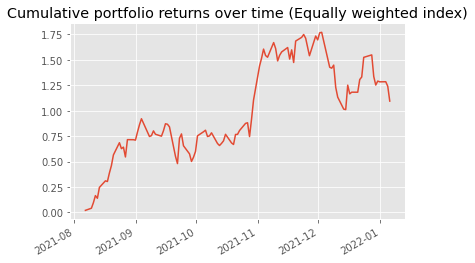

In [21]:
# How many stocks are in your portfolio?
numcoins = 7

# Create an array of equal weights across all assets
portfolio_weights_ew = np.repeat(1/numcoins, numcoins)


# Calculate the asset returns in our portfolio.
CoinReturns = coins.pct_change()[1:]

# Calculate the weighted stock returns
WeightedReturns = CoinReturns.mul(portfolio_weights_ew, axis=1)

# Calculate the portfolio returns
Portfolio_EW = WeightedReturns.sum(axis=1)

# Plot the cumulative portfolio returns over time
CumulativeReturns_EW = ((1+Portfolio_EW).cumprod()-1)
CumulativeReturns_EW.plot()
plt.title('Cumulative portfolio returns over time (Equally weighted index)')
plt.show()


### Market-cap weighted portfolios
Conversely, when large coins are doing well, market capitalization, or "market cap" weighted portfolios tend to outperform. This is because the largest weights are being assigned to the largest coins, or the coins with the largest market cap.

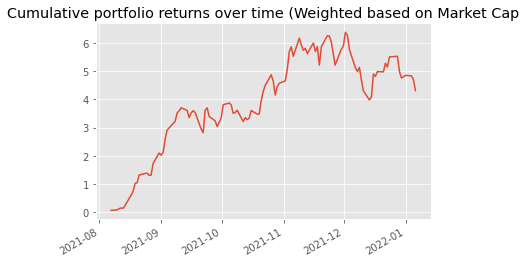

In [22]:
# Calculate the asset returns in our portfolio.
CoinReturns = coins.pct_change()[1:]

# Calculate the market cap weights
mcap_weights = np.array(table.market_caps / sum(table.market_caps))

# Calculate the market cap weighted portfolio returns
Portfolio_MCap = CoinReturns.mul(mcap_weights, axis=1).sum(axis=1)

CumulativeReturns_MCap = ((1+Portfolio_MCap).cumprod()-1)
CumulativeReturns_MCap.plot()
plt.title('Cumulative portfolio returns over time (Weighted based on Market Cap)')
plt.show()

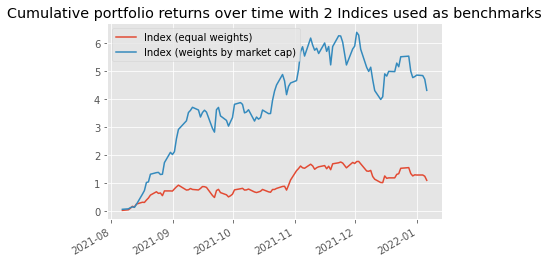

In [24]:
style.use("ggplot")
plt.title('Cumulative portfolio returns over time with 2 Indices used as benchmarks')
CumulativeReturns_EW.plot(label='Index (equal weights)')
CumulativeReturns_MCap.plot(label='Index (weights by market cap)')
plt.legend(loc=2)
plt.show()